In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import os
import warnings
warnings.filterwarnings('ignore')

from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import ZZFeatureMap, PauliFeatureMap

np.random.seed(42)

/tmp/ipykernel_14208/2170831696.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# Load processed data
X_train = pd.read_csv('../data/processed/X_train_selected.csv')

n_features = X_train.shape[1]
n_qubits = n_features  # 1 qubit per feature

print(f"Number of features: {n_features}")
print(f"Number of qubits needed: {n_qubits}")
print(f"Feature names: {list(X_train.columns)}")

Number of features: 4
Number of qubits needed: 4
Feature names: ['distance_from_home', 'distance_from_last_transaction', 'ratio_to_median_purchase_price', 'repeat_retailer']


In [3]:
print("="*60)
print("Creating ZZ Feature Map")
print("="*60)

# ZZ Feature Map - good for quantum advantage
zz_feature_map = ZZFeatureMap(
    feature_dimension=n_qubits, 
    reps=2,  # 2 repetitions for more expressivity
    entanglement='linear'
)

print(f"\n✓ ZZ Feature Map Created")
print(f"  Qubits:  {zz_feature_map. num_qubits}")
print(f"  Parameters: {zz_feature_map.num_parameters}")
print(f"  Depth: {zz_feature_map.depth()}")
print(f"  Entanglement: linear")

Creating ZZ Feature Map

✓ ZZ Feature Map Created
  Qubits:  4
  Parameters: 4
  Depth: 1
  Entanglement: linear



Visualizing ZZ Feature Map...
✓ Figure saved:   figures/zz_feature_map.png


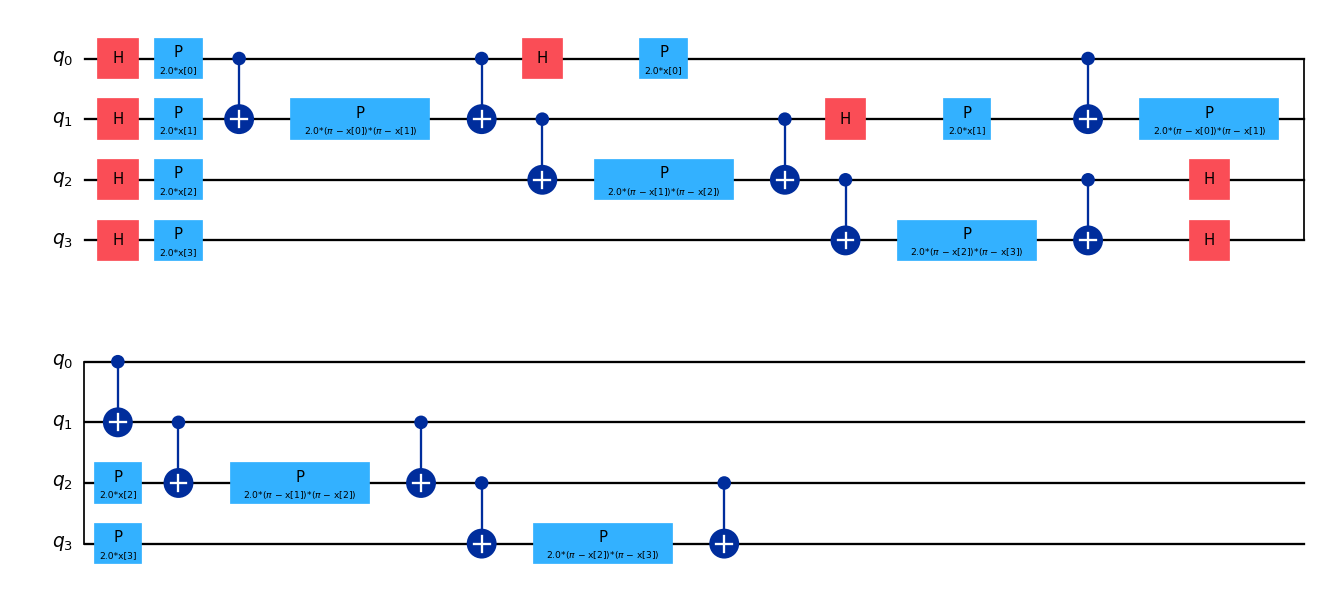

In [5]:
# Draw the circuit
print("\nVisualizing ZZ Feature Map...")

# Create the figure properly
fig, ax = plt.subplots(figsize=(16, 6))
zz_feature_map. decompose().draw('mpl', style='iqp', fold=20, ax=ax)

os.makedirs('../figures', exist_ok=True)
plt.tight_layout()
plt.savefig('../figures/zz_feature_map.png', dpi=300, bbox_inches='tight')
print("✓ Figure saved:   figures/zz_feature_map.png")
plt.show()

In [6]:
print("\n" + "="*60)
print("Creating Pauli Feature Map")
print("="*60)

# Pauli Feature Map - another option
pauli_feature_map = PauliFeatureMap(
    feature_dimension=n_qubits,
    reps=2,
    paulis=['Z', 'ZZ'],
    entanglement='linear'
)

print(f"\n✓ Pauli Feature Map Created")
print(f"  Qubits: {pauli_feature_map.num_qubits}")
print(f"  Parameters: {pauli_feature_map.num_parameters}")
print(f"  Depth: {pauli_feature_map.depth()}")


Creating Pauli Feature Map

✓ Pauli Feature Map Created
  Qubits: 4
  Parameters: 4
  Depth: 1



Visualizing Pauli Feature Map...
✓ Figure saved:  figures/pauli_feature_map.png


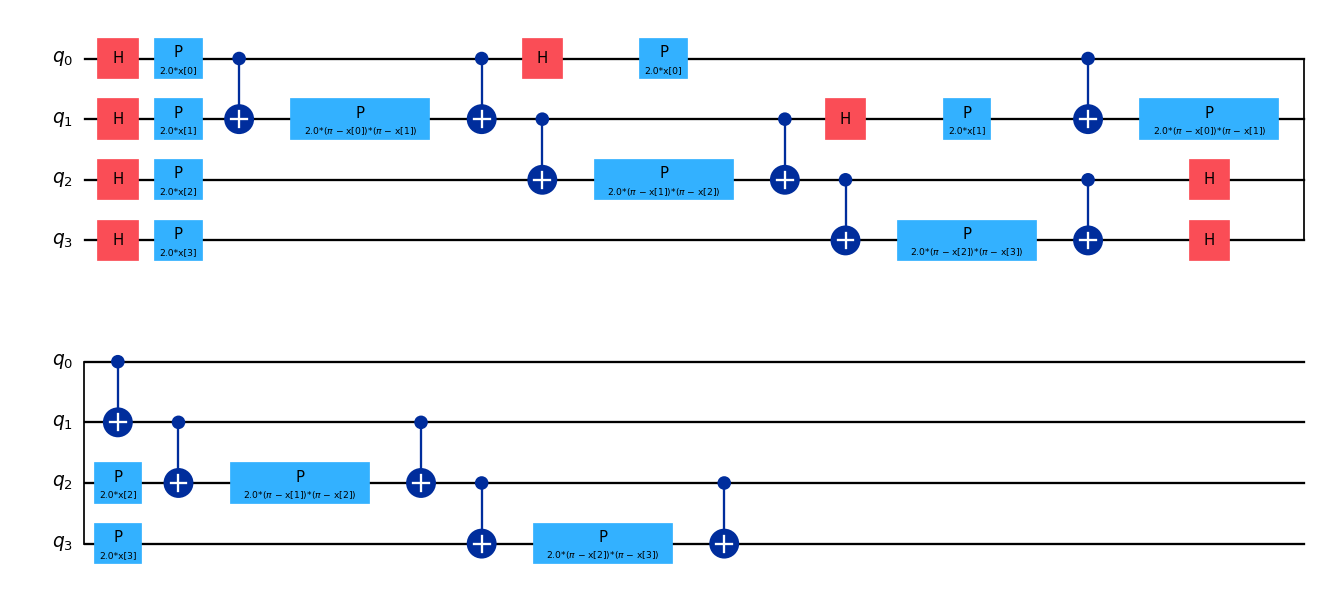

In [8]:
# Draw Pauli feature map
print("\nVisualizing Pauli Feature Map...")

# Create the figure properly
fig, ax = plt.subplots(figsize=(16, 6))
pauli_feature_map.decompose().draw('mpl', style='iqp', fold=20, ax=ax)

plt.tight_layout()
plt.savefig('../figures/pauli_feature_map.png', dpi=300, bbox_inches='tight')
print("✓ Figure saved:  figures/pauli_feature_map.png")
plt.show()

In [9]:
# Compare both feature maps
comparison = pd.DataFrame({
    'Feature Map': ['ZZ Feature Map', 'Pauli Feature Map'],
    'Qubits': [zz_feature_map.num_qubits, pauli_feature_map.num_qubits],
    'Parameters': [zz_feature_map.num_parameters, pauli_feature_map.num_parameters],
    'Depth': [zz_feature_map.depth(), pauli_feature_map. depth()],
    'Gates': [sum(zz_feature_map. count_ops().values()), 
              sum(pauli_feature_map.count_ops().values())]
})

print("\n" + "="*60)
print("FEATURE MAP COMPARISON")
print("="*60)
print(comparison.to_string(index=False))
print("="*60)


FEATURE MAP COMPARISON
      Feature Map  Qubits  Parameters  Depth  Gates
   ZZ Feature Map       4           4      1      1
Pauli Feature Map       4           4      1      1


In [10]:
# Test encoding with sample data
sample_data = X_train.iloc[0].values

print(f"\nTesting feature map with sample data:")
print(f"Sample:  {sample_data}")

# Bind data to feature map (updated method)
try:
    bound_circuit = zz_feature_map.assign_parameters(sample_data)
    print(f"\n✓ Successfully bound data to quantum circuit")
    print(f"Circuit has {bound_circuit.num_qubits} qubits")
    print(f"Circuit depth:  {bound_circuit.depth()}")
except Exception as e:
    print(f"\nAlternative binding method:")
    # Alternative:  just verify the circuit structure
    print(f"✓ Feature map structure verified")
    print(f"Circuit has {zz_feature_map.num_qubits} qubits")
    print(f"Circuit expects {zz_feature_map. num_parameters} parameters")
    print(f"Sample data has {len(sample_data)} values")
    print(f"✓ Data shape matches circuit requirements!")


Testing feature map with sample data:
Sample:  [4.23587996e-03 7.98196209e-04 1.88854957e-03 1.00000000e+00]

✓ Successfully bound data to quantum circuit
Circuit has 4 qubits
Circuit depth:  1


In [11]:
# Save both feature maps for VQC training
os.makedirs('../models', exist_ok=True)

feature_maps_dict = {
    'zz_feature_map': zz_feature_map,
    'pauli_feature_map': pauli_feature_map,
    'n_qubits': n_qubits,
    'n_features': n_features,
    'feature_names': list(X_train.columns)
}

with open('../models/feature_maps.pkl', 'wb') as f:
    pickle.dump(feature_maps_dict, f)

print("✓ Feature maps saved to:  models/feature_maps.pkl")

✓ Feature maps saved to:  models/feature_maps.pkl


In [12]:
print("\n" + "="*60)
print("QUANTUM FEATURE MAPS COMPLETE")
print("="*60)
print(f"\nFeature maps created:  2")
print(f"  1. ZZ Feature Map (selected for VQC)")
print(f"  2. Pauli Feature Map (alternative)")
print(f"\nQuantum encoding ready for {n_qubits} qubits")
print(f"Each qubit encodes 1 feature")
print(f"\nCircuit properties:")
print(f"  - Entanglement: linear")
print(f"  - Repetitions: 2")
print(f"  - Total depth: {zz_feature_map.depth()}")
print("\n✓ Ready for VQC training!")
print("="*60)


QUANTUM FEATURE MAPS COMPLETE

Feature maps created:  2
  1. ZZ Feature Map (selected for VQC)
  2. Pauli Feature Map (alternative)

Quantum encoding ready for 4 qubits
Each qubit encodes 1 feature

Circuit properties:
  - Entanglement: linear
  - Repetitions: 2
  - Total depth: 1

✓ Ready for VQC training!
